In [6]:
#load saved model
import tensorflow as tf
generator1 = tf.keras.models.load_model('original_dcgan_mnist2')

In [7]:
# generate 60000 images
with tf.device('/gpu:0'):
    batch = 256
    generated_images1 = None
    for i in range(200):
       tf.random.set_seed(i)
       noise = tf.random.normal([batch, 100])
       generated_image1 = generator1(noise)
       if generated_images1 is None:
          generated_images1 = generated_image1
       else:
          generated_images1 = tf.concat([generated_images1, generated_image1], axis=0)

2023-05-19 20:49:23.644811: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-19 20:49:23.663326: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2023-05-19 20:49:23.673343: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-19 20:49:23.840382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


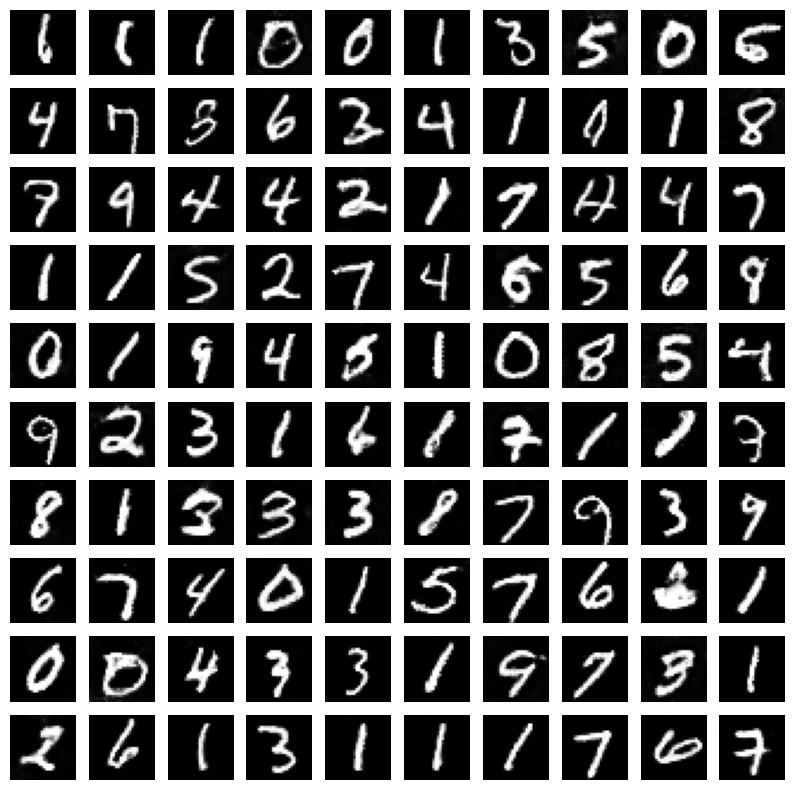

In [8]:
#display generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated_images1[i+200, :, :, 0], cmap='gray')
  plt.axis('off')

In [9]:
generated_images1.shape

TensorShape([51200, 28, 28, 1])

In [1]:
import tensorflow as tf
import numpy as np
#load and preprocess data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images-127.5)/127.5

BUFFER_SIZE = 50000
batch_size=64

# Concatenate
all_images = np.concatenate([train_images, test_images], axis=0)

# Batch and shuffle the data
all_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(batch_size)


channels_axis = -1
#setup inception network
from keras.applications.inception_v3 import InceptionV3
inception_v3 = InceptionV3(include_top=False, pooling='avg')
pool_size = inception_v3.output_shape[-1]

num_batches=1


mean = np.zeros(pool_size)
cov = np.zeros((pool_size, pool_size))
N = 0
for i in range(num_batches):
    batch = next(iter(all_dataset))
    if batch.shape[channels_axis] == 1:
		   batch = np.concatenate([batch]*3, axis=channels_axis)

2023-05-20 10:11:19.840798: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-20 10:11:21.172250: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-20 10:11:21.173206: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-20 10:11:21.200071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-20 10:11:21.200258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-20 10:1

In [2]:
batch.shape

(64, 28, 28, 3)

In [5]:
import tensorflow as tf
min_val = tf.reduce_min(generated_images1)
max_val = tf.reduce_max(generated_images1)
min_val, max_val

(<tf.Tensor: shape=(), dtype=float32, numpy=-1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9999998>)

In [21]:
import tensorflow as tf
import numpy as np
#load and preprocess data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images-127.5)/127.5

BUFFER_SIZE = 50000
BATCH_SIZE = 64

# Concatenate
all_images = np.concatenate([train_images, test_images], axis=0)

# Batch and shuffle the data
all_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Function to resize images
def resize_image(image):
    image = tf.image.resize(image, [299, 299])
    image = tf.repeat(image, 3, axis=-1) # Repeat the grayscale image 3 times to create a 3-channel image
    return image

# Apply the resize function to all images in the dataset
all_dataset_resized = all_dataset.map(resize_image)

model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Initialize a list to hold predictions
predictions = []

# Iterate over each batch in the dataset
for batch in all_dataset_resized:
    # Make predictions for the current batch and add them to the list of predictions
    predictions.extend(model.predict(batch))

# Convert the list of predictions to a numpy array
act1 = np.array(predictions)

# Batch and shuffle the generated data
generated_dataset = tf.data.Dataset.from_tensor_slices(generated_images1).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Apply the resize function to all generated images in the dataset
generated_dataset_resized = generated_dataset.map(resize_image)

# Initialize a list to hold predictions
predictions2 = []

# Iterate over each batch in the dataset
for batch in generated_dataset_resized:
    # Make predictions for the current batch and add them to the list of predictions
    predictions2.extend(model.predict(batch))

# Convert the list of predictions to a numpy array
act2 = np.array(predictions2)

# images1 = tf.keras.applications.inception_v3.preprocess_input(act1)
# images2 = tf.keras.applications.inception_v3.preprocess_input(act2)

images1 = act1
images2 = act2

from scipy.linalg import sqrtm
# calculate mean and covariance statistics
mu1, sigma1 = act1.mean(axis=0), np.cov(images1, rowvar=False)
mu2, sigma2 = act2.mean(axis=0), np.cov(images2, rowvar=False)
# calculate sum squared difference between means
ssdiff = np.sum((mu1 - mu2)**2.0)
# calculate sqrt of product between cov
covmean = sqrtm(sigma1.dot(sigma2))
# check and correct imaginary numbers from sqrt
if np.iscomplexobj(covmean):
   covmean = covmean.real
# calculate score
fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

In [22]:
fid

13.120015681243627

In [ ]:
#load saved model
import tensorflow as tf
generator = tf.keras.models.load_model('original_dcgan_fashion_mnist2')

In [2]:
# generate 60000 images
with tf.device('/gpu:0'):
    batch = 256
    generated_images = None
    for i in range(300):
       tf.random.set_seed(i)
       noise = tf.random.normal([batch, 100])
       generated_image = generator(noise)
       if generated_images is None:
          generated_images = generated_image
       else:
          generated_images = tf.concat([generated_images, generated_image], axis=0)

2023-05-15 22:33:43.770220: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-15 22:33:43.791369: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2023-05-15 22:33:43.800438: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-15 22:33:43.999305: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


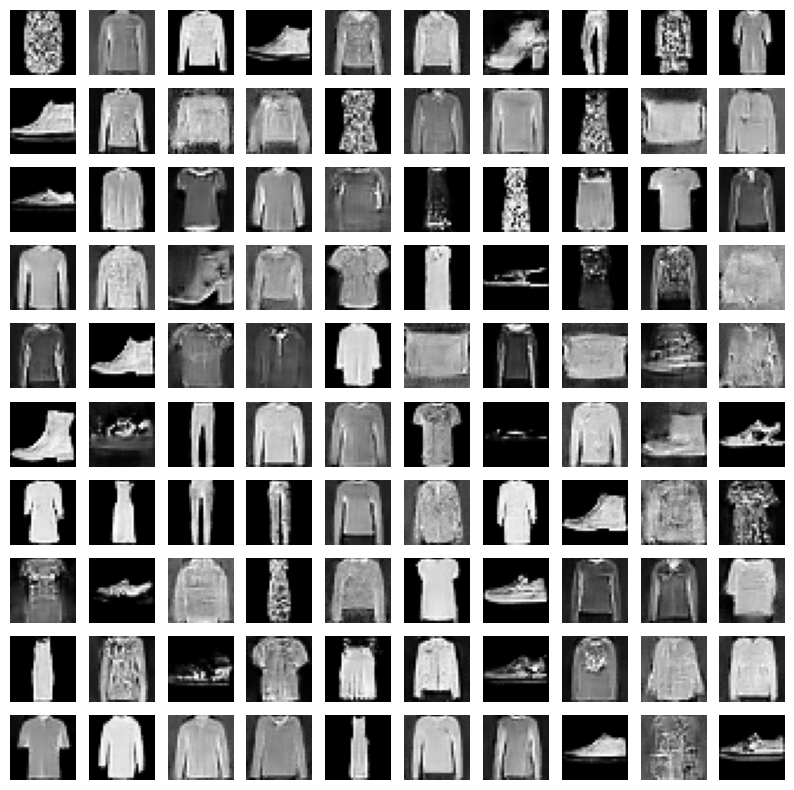

In [3]:
#display generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated_images[i+200, :, :, 0], cmap='gray')
  plt.axis('off')

## Frechet Inception Distance (FID) for Evaluating GANs

In [4]:
import tensorflow as tf
import numpy as np
#load and preprocess data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images-127.5)/127.5

BUFFER_SIZE = 70000
BATCH_SIZE = 200

# Concatenate
all_images = np.concatenate([train_images, test_images], axis=0)

# Batch and shuffle the data
all_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Function to resize images
def resize_image(image):
    image = tf.image.resize(image, [299, 299])
    image = tf.repeat(image, 3, axis=-1) # Repeat the grayscale image 3 times to create a 3-channel image
    return image

# Apply the resize function to all images in the dataset
all_dataset_resized = all_dataset.map(resize_image)

model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Initialize a list to hold predictions
predictions = []

# Iterate over each batch in the dataset
for batch in all_dataset_resized:
    # Make predictions for the current batch and add them to the list of predictions
    predictions.extend(model.predict(batch))

# Convert the list of predictions to a numpy array
act1 = np.array(predictions)

# Batch and shuffle the generated data
generated_dataset = tf.data.Dataset.from_tensor_slices(generated_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Apply the resize function to all generated images in the dataset
generated_dataset_resized = generated_dataset.map(resize_image)

# Initialize a list to hold predictions
predictions2 = []

# Iterate over each batch in the dataset
for batch in generated_dataset_resized:
    # Make predictions for the current batch and add them to the list of predictions
    predictions2.extend(model.predict(batch))

# Convert the list of predictions to a numpy array
act2 = np.array(predictions2)

images1 = tf.keras.applications.inception_v3.preprocess_input(act1)
images2 = tf.keras.applications.inception_v3.preprocess_input(act2)

from scipy.linalg import sqrtm
# calculate mean and covariance statistics
mu1, sigma1 = act1.mean(axis=0), np.cov(images1, rowvar=False)
mu2, sigma2 = act2.mean(axis=0), np.cov(images1, rowvar=False)
# calculate sum squared difference between means
ssdiff = np.sum((mu1 - mu2)**2.0)
# calculate sqrt of product between cov
covmean = sqrtm(sigma1.dot(sigma2))
# check and correct imaginary numbers from sqrt
if np.iscomplexobj(covmean):
   covmean = covmean.real
# calculate score
fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

In [5]:
fid

0.0009871985530484236

In [2]:
#load saved model
import tensorflow as tf
generator_pruned_fashion = tf.keras.models.load_model('pruned_dcgan_fashion_mnist2')

In [3]:
# generate 60000 images
with tf.device('/gpu:0'):
    batch = 256
    generated_images = None
    for i in range(300):
       tf.random.set_seed(i)
       noise = tf.random.normal([batch, 100])
       generated_image = generator_pruned_fashion(noise)
       if generated_images is None:
          generated_images = generated_image
       else:
          generated_images = tf.concat([generated_images, generated_image], axis=0)

2023-05-16 10:17:56.701224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-16 10:17:56.719365: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2023-05-16 10:17:56.728605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-16 10:17:56.929280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


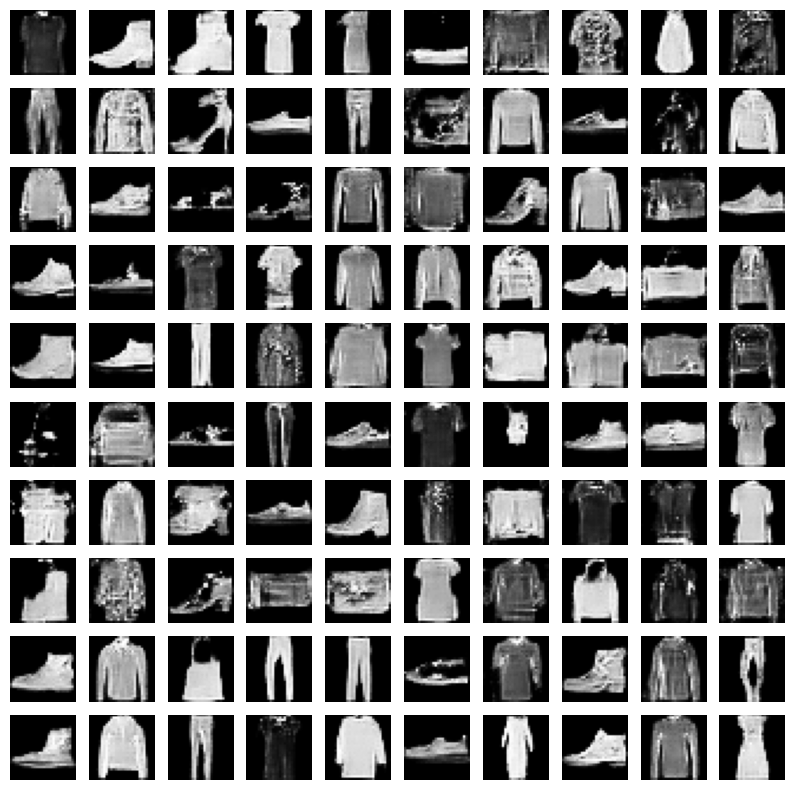

In [4]:
#display generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated_images[i+200, :, :, 0], cmap='gray')
  plt.axis('off')

In [5]:
import tensorflow as tf
import numpy as np
#load and preprocess data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images-127.5)/127.5

BUFFER_SIZE = 70000
BATCH_SIZE = 200

# Concatenate
all_images = np.concatenate([train_images, test_images], axis=0)

# Batch and shuffle the data
all_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Function to resize images
def resize_image(image):
    image = tf.image.resize(image, [299, 299])
    image = tf.repeat(image, 3, axis=-1) # Repeat the grayscale image 3 times to create a 3-channel image
    return image

# Apply the resize function to all images in the dataset
all_dataset_resized = all_dataset.map(resize_image)

model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Initialize a list to hold predictions
predictions = []

# Iterate over each batch in the dataset
for batch in all_dataset_resized:
    # Make predictions for the current batch and add them to the list of predictions
    predictions.extend(model.predict(batch))

# Convert the list of predictions to a numpy array
act1 = np.array(predictions)

# Batch and shuffle the generated data
generated_dataset = tf.data.Dataset.from_tensor_slices(generated_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Apply the resize function to all generated images in the dataset
generated_dataset_resized = generated_dataset.map(resize_image)

# Initialize a list to hold predictions
predictions2 = []

# Iterate over each batch in the dataset
for batch in generated_dataset_resized:
    # Make predictions for the current batch and add them to the list of predictions
    predictions2.extend(model.predict(batch))

# Convert the list of predictions to a numpy array
act2 = np.array(predictions2)

images1 = tf.keras.applications.inception_v3.preprocess_input(act1)
images2 = tf.keras.applications.inception_v3.preprocess_input(act2)

from scipy.linalg import sqrtm
# calculate mean and covariance statistics
mu1, sigma1 = act1.mean(axis=0), np.cov(images1, rowvar=False)
mu2, sigma2 = act2.mean(axis=0), np.cov(images1, rowvar=False)
# calculate sum squared difference between means
ssdiff = np.sum((mu1 - mu2)**2.0)
# calculate sqrt of product between cov
covmean = sqrtm(sigma1.dot(sigma2))
# check and correct imaginary numbers from sqrt
if np.iscomplexobj(covmean):
   covmean = covmean.real
# calculate score
fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

In [6]:
fid

0.0007935364264998352

## transfer 

In [1]:
#load saved model
import tensorflow as tf
generator = tf.keras.models.load_model('pruned_dcgan_fashion_mnist_trained_on_mnist')

2023-05-16 18:30:47.171670: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-16 18:30:48.092631: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-16 18:30:48.093394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-16 18:30:48.117836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-16 18:30:48.118065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-16 18:3

In [2]:
# generate 60000 images
with tf.device('/gpu:0'):
    batch = 256
    generated_images = None
    for i in range(300):
       tf.random.set_seed(i)
       noise = tf.random.normal([batch, 100])
       generated_image = generator(noise)
       if generated_images is None:
          generated_images = generated_image
       else:
          generated_images = tf.concat([generated_images, generated_image], axis=0)

2023-05-16 18:31:52.203243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-16 18:31:52.223396: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2023-05-16 18:31:52.231948: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-16 18:31:52.433586: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


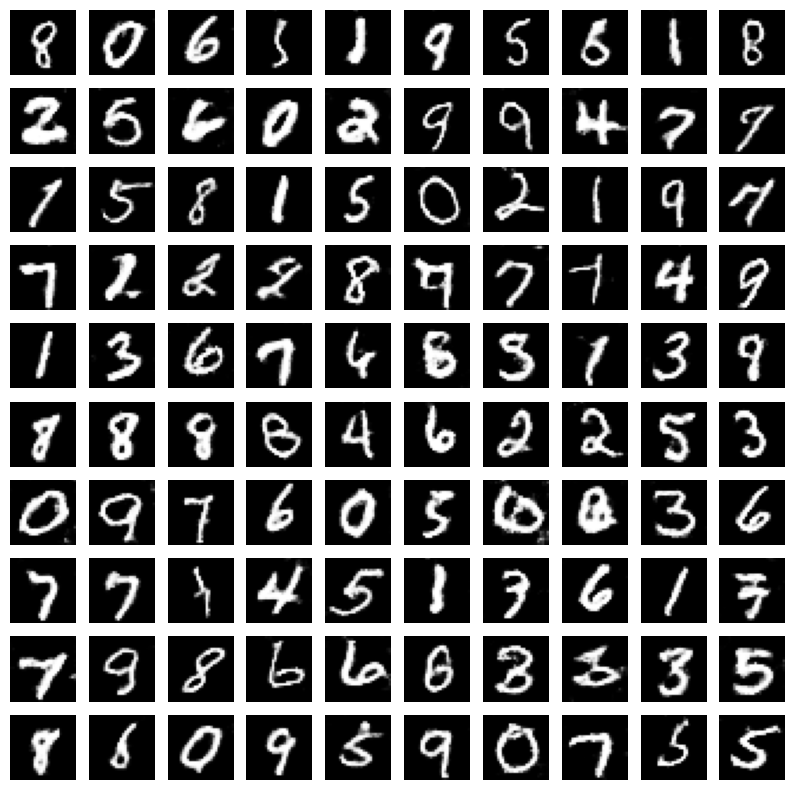

In [3]:
#display generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated_images[i+200, :, :, 0], cmap='gray')
  plt.axis('off')

In [4]:
import tensorflow as tf
import numpy as np
#load and preprocess data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images-127.5)/127.5

BUFFER_SIZE = 70000
BATCH_SIZE = 200

# Concatenate
all_images = np.concatenate([train_images, test_images], axis=0)

# Batch and shuffle the data
all_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Function to resize images
def resize_image(image):
    image = tf.image.resize(image, [299, 299])
    image = tf.repeat(image, 3, axis=-1) # Repeat the grayscale image 3 times to create a 3-channel image
    return image

# Apply the resize function to all images in the dataset
all_dataset_resized = all_dataset.map(resize_image)

model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Initialize a list to hold predictions
predictions = []

# Iterate over each batch in the dataset
for batch in all_dataset_resized:
    # Make predictions for the current batch and add them to the list of predictions
    predictions.extend(model.predict(batch))

# Convert the list of predictions to a numpy array
act1 = np.array(predictions)

# Batch and shuffle the generated data
generated_dataset = tf.data.Dataset.from_tensor_slices(generated_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Apply the resize function to all generated images in the dataset
generated_dataset_resized = generated_dataset.map(resize_image)

# Initialize a list to hold predictions
predictions2 = []

# Iterate over each batch in the dataset
for batch in generated_dataset_resized:
    # Make predictions for the current batch and add them to the list of predictions
    predictions2.extend(model.predict(batch))

# Convert the list of predictions to a numpy array
act2 = np.array(predictions2)

images1 = tf.keras.applications.inception_v3.preprocess_input(act1)
images2 = tf.keras.applications.inception_v3.preprocess_input(act2)

from scipy.linalg import sqrtm
# calculate mean and covariance statistics
mu1, sigma1 = act1.mean(axis=0), np.cov(images1, rowvar=False)
mu2, sigma2 = act2.mean(axis=0), np.cov(images1, rowvar=False)
# calculate sum squared difference between means
ssdiff = np.sum((mu1 - mu2)**2.0)
# calculate sqrt of product between cov
covmean = sqrtm(sigma1.dot(sigma2))
# check and correct imaginary numbers from sqrt
if np.iscomplexobj(covmean):
   covmean = covmean.real
# calculate score
fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

In [5]:
fid

0.008644602261484018

In [6]:
#compute Inception Score
#load saved model
with tf.device('/gpu:0'):
   classifier = tf.keras.models.load_model('mnistclassification')
   #compute the output of classification model for generated data
   probs = None
   for i in range(300):
       prob = classifier(generated_images[200*i:200*(i+1)])
       if probs is None:
           probs = prob
       else:
           probs = tf.concat([probs, prob], axis=0)

   #compute inception score
   p_yx = probs
   p_y = tf.expand_dims(tf.reduce_mean(p_yx, axis=0), 0)
   eps=1E-16
   # kl divergence for each image
   kl_d = p_yx * (tf.math.log(p_yx + eps) - tf.math.log(p_y + eps))
   sum_kl_d = tf.reduce_sum(kl_d, axis=1)
   avg_kl_d = tf.reduce_mean(sum_kl_d)
   is_score = tf.math.exp(avg_kl_d)
is_score

<tf.Tensor: shape=(), dtype=float32, numpy=9.308675>

## generate data with trained pruned generator (SNIP_GAN)

In [4]:
#load saved model
import tensorflow as tf
generator = tf.keras.models.load_model('pruned_snip_dcgan_mnist')

In [5]:
# generate 60000 images
with tf.device('/gpu:0'):
    batch = 200
    generated_images = None
    for i in range(300):
       tf.random.set_seed(i)
       noise = tf.random.normal([batch, 100])
       generated_image = generator(noise)
       if generated_images is None:
          generated_images = generated_image
       else:
          generated_images = tf.concat([generated_images, generated_image], axis=0)

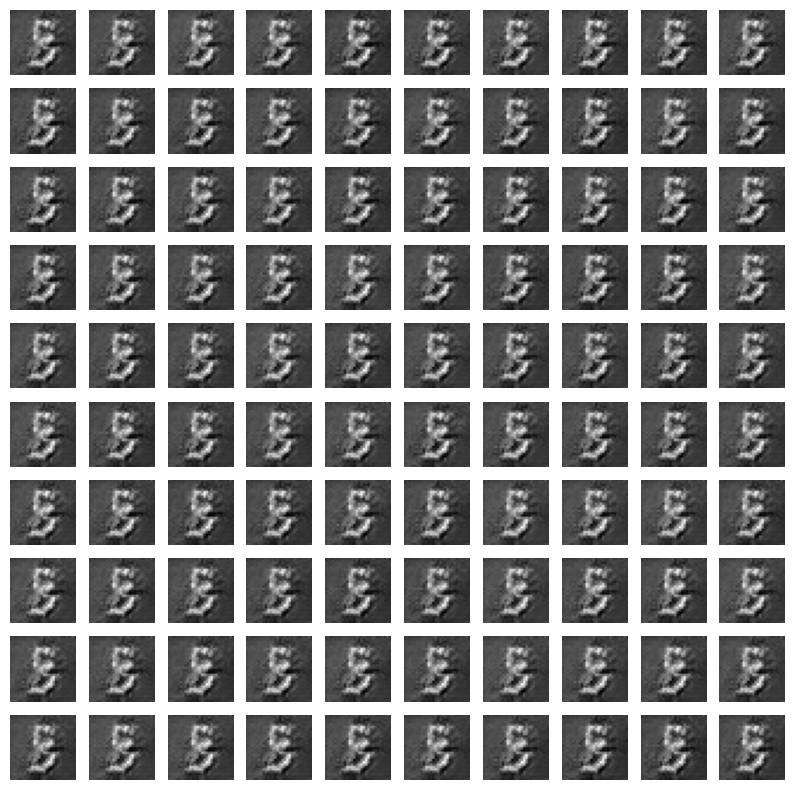

In [6]:
#display generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated_images[i+200, :, :, 0], cmap='gray')
  plt.axis('off')

2023-05-14 23:18:48.111115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-14 23:18:49.400868: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-14 23:18:49.401677: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-14 23:18:49.427930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-14 23:18:49.428122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-14 23:1

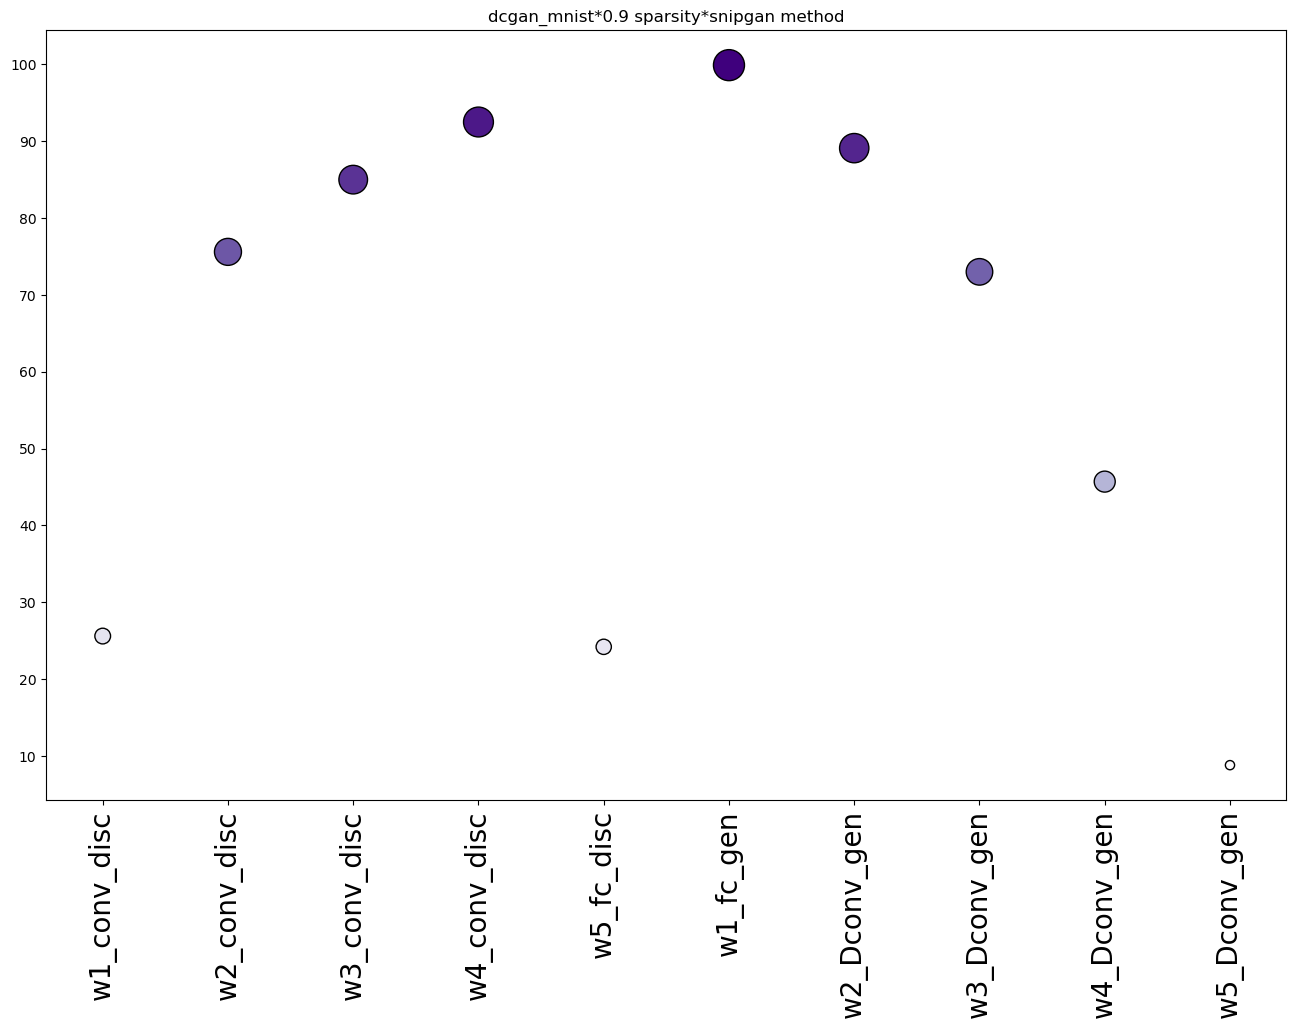

<Figure size 640x480 with 0 Axes>

In [1]:
from compute_GAN import visual_sparsity_layer
import tensorflow as tf
with tf.device('/gpu:0'):
     visual_sparsity_layer('mnist', 'dcgan_mnist', 'SNIP_GAN', 200, 0.9)

## generate data with trained pruned model with SNIP_GAN2

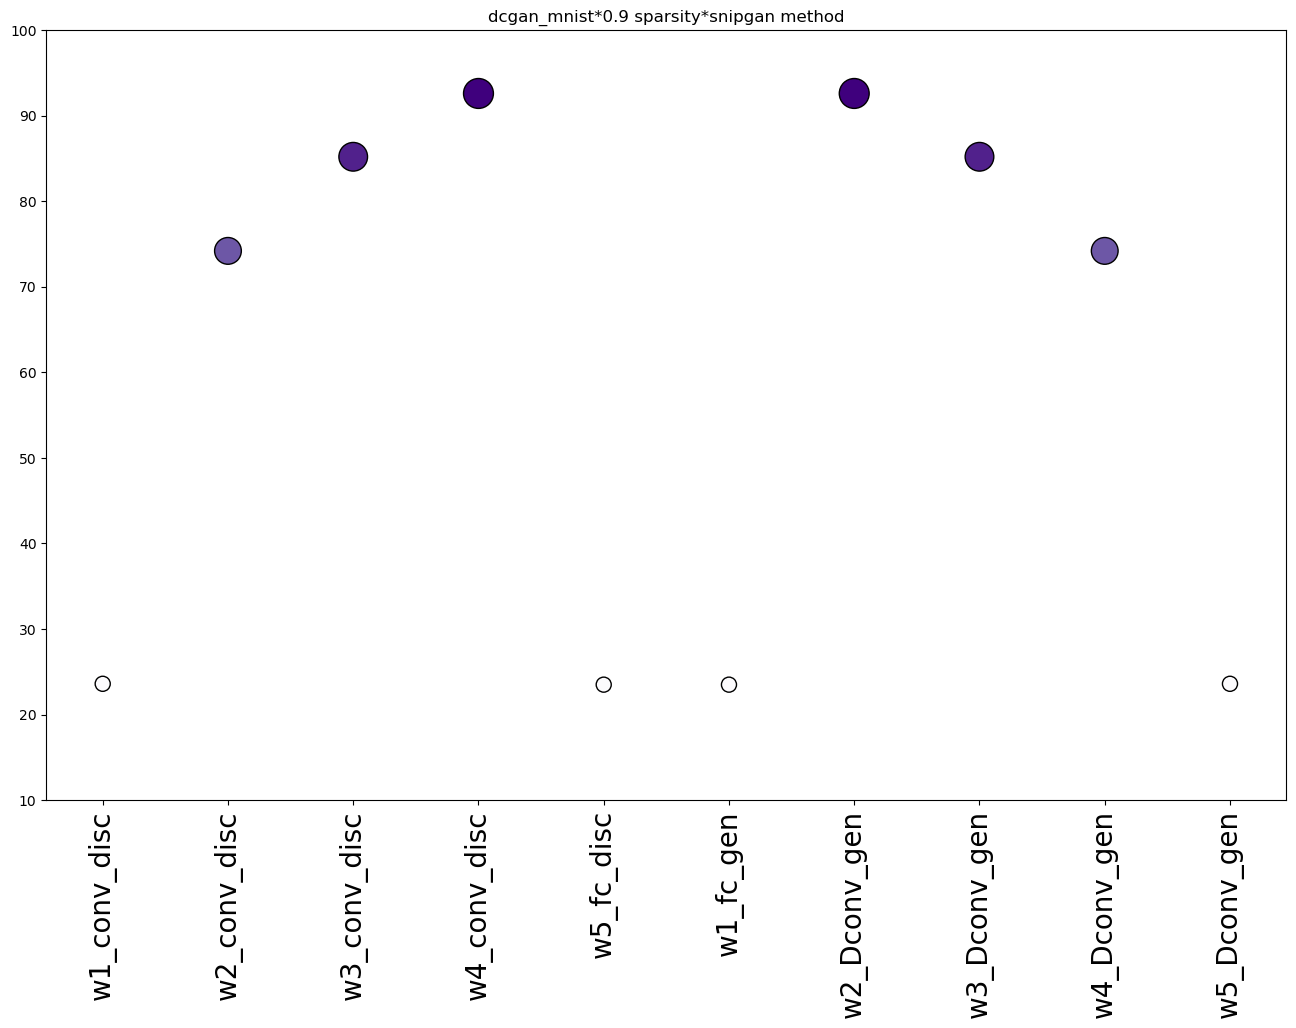

<Figure size 640x480 with 0 Axes>

In [2]:
from compute_GAN import visual_sparsity_layer
import tensorflow as tf
with tf.device('/gpu:0'):
     visual_sparsity_layer('mnist', 'dcgan_mnist', 'SNIP_GAN2', 200, 0.9)

In [3]:
#percentage of pruned parameters in discriminator and generator
from compute_GAN import compute_mask
import tensorflow as tf
import numpy as np
with tf.device('/gpu:0'):
    final_w_disc, mask_disc, final_w_gen, mask_gen = compute_mask('mnist', 'dcgan_mnist', 'SNIP_GAN2', 200, 0.9)
    mask_gen_flattened = tf.concat([tf.reshape(mask_gen[k], [-1]) for k in mask_gen.keys()], axis=0) 
    num_ones_gen = np.count_nonzero(mask_gen_flattened == 1)
    percent_ones_gen = (num_ones_gen / len(mask_gen_flattened)) * 100
    mask_disc_flattened = tf.concat([tf.reshape(mask_disc[k], [-1]) for k in mask_disc.keys()], axis=0) 
    num_ones_disc = np.count_nonzero(mask_disc_flattened == 1)
    percent_ones_disc = (num_ones_disc / len(mask_disc_flattened)) * 100

percent_ones_gen, percent_ones_disc 

(42.84547000618429, 10.00003703374515)

In [4]:
#load saved model
import tensorflow as tf
with tf.device('/gpu:0'):
    generator2 = tf.keras.models.load_model('pruned_snip2_dcgan_mnist')

In [5]:
# generate 60000 images
with tf.device('/gpu:0'):
    batch = 200
    generated_images2 = None
    for i in range(300):
       tf.random.set_seed(i)
       noise = tf.random.normal([batch, 100])
       generated_image2 = generator2(noise)
       if generated_images2 is None:
          generated_images2 = generated_image2
       else:
          generated_images2 = tf.concat([generated_images2, generated_image2], axis=0)

2023-05-14 23:20:12.342059: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-14 23:20:12.359362: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


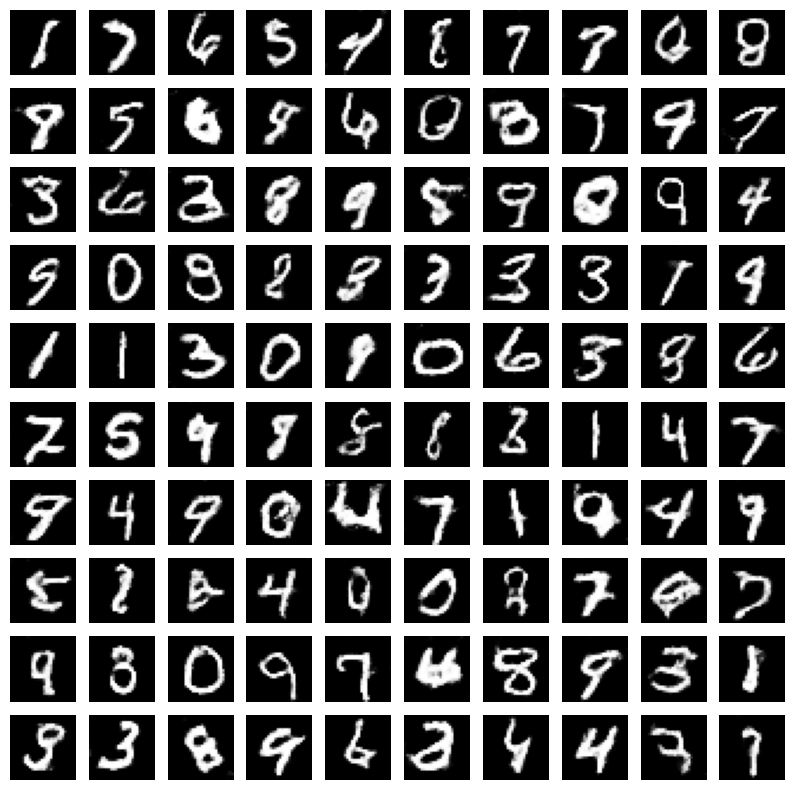

In [6]:
#display generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated_images2[i+200, :, :, 0], cmap='gray')
  plt.axis('off')

In [10]:
#compute Inception Score
#load saved model
with tf.device('/gpu:0'):
   classifier = tf.keras.models.load_model('mnistclassification')
   #compute the output of classification model for generated data
   probs = None
   for i in range(300):
       prob = classifier(generated_images2[200*i:200*(i+1)])
       if probs is None:
           probs = prob
       else:
           probs = tf.concat([probs, prob], axis=0)

   #compute inception score
   p_yx = probs
   p_y = tf.expand_dims(tf.reduce_mean(p_yx, axis=0), 0)
   eps=1E-16
   # kl divergence for each image
   kl_d = p_yx * (tf.math.log(p_yx + eps) - tf.math.log(p_y + eps))
   sum_kl_d = tf.reduce_sum(kl_d, axis=1)
   avg_kl_d = tf.reduce_mean(sum_kl_d)
   is_score = tf.math.exp(avg_kl_d)
is_score

<tf.Tensor: shape=(), dtype=float32, numpy=8.940349>

## generate images with original generative model

In [2]:
#load saved model
import tensorflow as tf
with tf.device('/gpu:0'):
    generator3 = tf.keras.models.load_model('original_dcgan_mnist')

In [3]:
# generate 60000 images
with tf.device('/gpu:0'):
    batch = 200
    generated_images3 = None
    for i in range(300):
       tf.random.set_seed(i)
       noise = tf.random.normal([batch, 100])
       generated_image3 = generator3(noise)
       if generated_images3 is None:
          generated_images3 = generated_image3
       else:
          generated_images3 = tf.concat([generated_images3, generated_image3], axis=0)

2023-05-17 21:43:52.632808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-17 21:43:52.651291: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2023-05-17 21:43:52.661981: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-17 21:43:52.850258: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


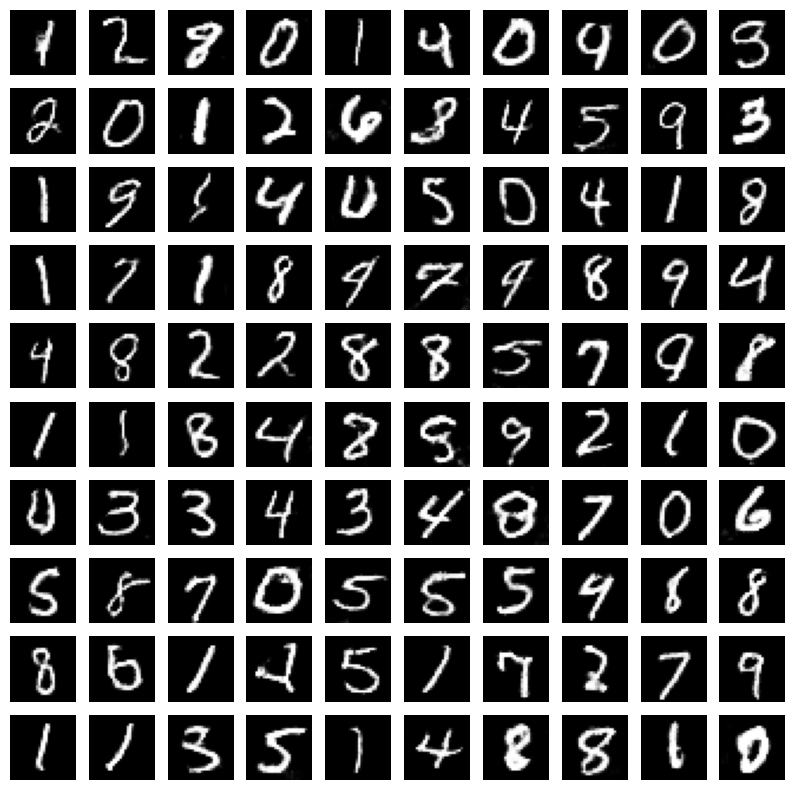

In [4]:
#display generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated_images3[i+200, :, :, 0], cmap='gray')
  plt.axis('off')

In [10]:
import tensorflow as tf
import numpy as np
#load and preprocess data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images-127.5)/127.5

BUFFER_SIZE = 70000
BATCH_SIZE = 200

# Concatenate
all_images = np.concatenate([train_images, test_images], axis=0)

# Batch and shuffle the data
all_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Function to resize images
def resize_image(image):
    image = tf.image.resize(image, [299, 299])
    image = tf.repeat(image, 3, axis=-1) # Repeat the grayscale image 3 times to create a 3-channel image
    return image

# Apply the resize function to all images in the dataset
all_dataset_resized = all_dataset.map(resize_image)

model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

images1 = []
for batch in all_dataset_resized:
      images1.extend(tf.keras.applications.inception_v3.preprocess_input(batch))

2023-05-17 22:48:41.359575: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 204.62MiB (rounded to 214562560)requested by op Sub
Current allocation summary follows.
2023-05-17 22:48:41.360681: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2023-05-17 22:48:41.360710: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 323, Chunks in use: 322. 80.8KiB allocated for chunks. 80.5KiB in use in bin. 52.1KiB client-requested in use in bin.
2023-05-17 22:48:41.360726: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 673, Chunks in use: 671. 461.2KiB allocated for chunks. 460.0KiB in use in bin. 425.8KiB client-requested in use in bin.
2023-05-17 22:48:41.360740: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 224, Chunks in use: 222. 326.2KiB allocated for chunks. 323.2KiB in use in bin. 315.3KiB

ResourceExhaustedError: OOM when allocating tensor with shape[200,299,299,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Sub]

In [ ]:
import tensorflow as tf
import numpy as np
#load and preprocess data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images-127.5)/127.5

BUFFER_SIZE = 70000
BATCH_SIZE = 200

# Concatenate
all_images = np.concatenate([train_images, test_images], axis=0)

# Batch and shuffle the data
all_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Function to resize images
def resize_image(image):
    image = tf.image.resize(image, [299, 299])
    image = tf.repeat(image, 3, axis=-1) # Repeat the grayscale image 3 times to create a 3-channel image
    return image

# Apply the resize function to all images in the dataset
all_dataset_resized = all_dataset.map(resize_image)

model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Initialize a list to hold predictions
predictions = []

# Iterate over each batch in the dataset
for batch in all_dataset_resized:
    # Make predictions for the current batch and add them to the list of predictions
    predictions.extend(model.predict(batch))

# Convert the list of predictions to a numpy array
act1 = np.array(predictions)

# Batch and shuffle the generated data
generated_dataset = tf.data.Dataset.from_tensor_slices(generated_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Apply the resize function to all generated images in the dataset
generated_dataset_resized = generated_dataset.map(resize_image)






# Initialize a list to hold predictions
predictions2 = []

# Iterate over each batch in the dataset
for batch in generated_dataset_resized:
    # Make predictions for the current batch and add them to the list of predictions
    predictions2.extend(model.predict(batch))

# Convert the list of predictions to a numpy array
act2 = np.array(predictions2)

images1 = tf.keras.applications.inception_v3.preprocess_input(act1)
images2 = tf.keras.applications.inception_v3.preprocess_input(act2)

from scipy.linalg import sqrtm
# calculate mean and covariance statistics
mu1, sigma1 = act1.mean(axis=0), np.cov(images1, rowvar=False)
mu2, sigma2 = act2.mean(axis=0), np.cov(images1, rowvar=False)
# calculate sum squared difference between means
ssdiff = np.sum((mu1 - mu2)**2.0)
# calculate sqrt of product between cov
covmean = sqrtm(sigma1.dot(sigma2))
# check and correct imaginary numbers from sqrt
if np.iscomplexobj(covmean):
   covmean = covmean.real
# calculate score
fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

In [6]:
#compute Inception Score
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.stats import entropy

# Load the InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Assuming gen_images is your array of generated images
gen_images3 = (generated_images3 + 1) / 2  # Un-normalize images to [0,1] range

# Upscale images to fit into Inception v3 and repeat single channel three times to make it 3-channel image
gen_images_upscaled = tf.image.resize(gen_images3, (299,299))
gen_images_upscaled = tf.repeat(gen_images_upscaled, 3, -1)

# Preprocess the input for inception v3
gen_images_upscaled = preprocess_input(gen_images_upscaled)

2023-05-17 21:45:49.021135: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 59.95GiB (rounded to 64368720128)requested by op Tile
Current allocation summary follows.
2023-05-17 21:45:49.021256: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2023-05-17 21:45:49.021278: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 315, Chunks in use: 314. 78.8KiB allocated for chunks. 78.5KiB in use in bin. 52.1KiB client-requested in use in bin.
2023-05-17 21:45:49.021293: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 685, Chunks in use: 683. 468.5KiB allocated for chunks. 467.2KiB in use in bin. 434.1KiB client-requested in use in bin.
2023-05-17 21:45:49.021307: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 216, Chunks in use: 213. 319.5KiB allocated for chunks. 315.0KiB in use in bin. 311.9K

ResourceExhaustedError: OOM when allocating tensor with shape[60000,299,299,1,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Tile]

### compute Inception Score

#model for classifying generated images

import tensorflow as tf

inp = tf.keras.layers.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid')(inp)

x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid')(x)

x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='valid')(x)

x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='valid')(x)

x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='valid')(x)

x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = tf.keras.layers.BatchNormalization()(x)
 
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(units=512, activation='relu')(x)

x = tf.keras.layers.Dense(units=10, activation='softmax')(x)

classification_model = tf.keras.models.Model(inp, x)

classification_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images = (train_images-127.5)/127.5

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

test_images = (test_images-127.5)/127.5

history = classification_model.fit(train_images, train_labels, batch_size=128,  epochs=20, validation_split=0.2)

classification_model.save('mnistclassification')

In [19]:
#load saved model
classifier = tf.keras.models.load_model('mnistclassification')

In [21]:
with tf.device('/gpu:1'):
    classifier(generated_images[0:1])

In [23]:
#compute the output of classification model for generated data
with tf.device('/gpu:1'):
    probs = None
    for i in range(300):
        prob = classifier(generated_images[200*i:200*(i+1)])
        if probs is None:
            probs = prob
        else:
            probs = tf.concat([probs, prob], axis=0)
    probs.shape

In [24]:
#compute inception score
p_yx = probs
p_y = tf.expand_dims(tf.reduce_mean(p_yx, axis=0), 0)
eps=1E-16
# kl divergence for each image
kl_d = p_yx * (tf.math.log(p_yx + eps) - tf.math.log(p_y + eps))
sum_kl_d = tf.reduce_sum(kl_d, axis=1)
avg_kl_d = tf.reduce_mean(sum_kl_d)
is_score = tf.math.exp(avg_kl_d)
is_score

<tf.Tensor: shape=(), dtype=float32, numpy=1.0000093>

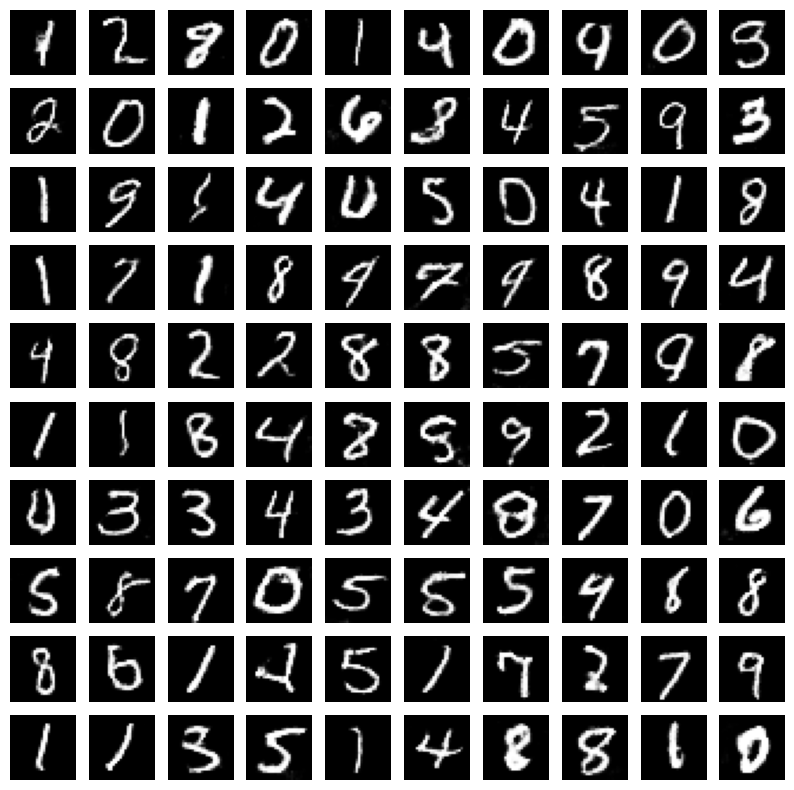

: 

In [9]:
#display generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated_images3[i+200, :, :, 0], cmap='gray')
  plt.axis('off')

In [24]:
#compute Inception Score
#load saved model
classifier = tf.keras.models.load_model('mnistclassification')
#compute the output of classification model for generated data
probs = None
for i in range(300):
    prob = classifier(generated_images[200*i:200*(i+1)])
    if probs is None:
        probs = prob
    else:
        probs = tf.concat([probs, prob], axis=0)

#compute inception score
p_yx = probs
p_y = tf.expand_dims(tf.reduce_mean(p_yx, axis=0), 0)
eps=1E-16
# kl divergence for each image
kl_d = p_yx * (tf.math.log(p_yx + eps) - tf.math.log(p_y + eps))
sum_kl_d = tf.reduce_sum(kl_d, axis=1)
avg_kl_d = tf.reduce_mean(sum_kl_d)
is_score = tf.math.exp(avg_kl_d)

In [25]:
is_score

<tf.Tensor: shape=(), dtype=float32, numpy=9.081903>